# Multiclass Support Vector Machine exercise
翻译：多分类支持向量机训练

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

翻译：当你提交作业时，完成并提交此工作表（包括它的输出以及任何用到的在此工作表外的code）。更多的细节请看课程网页：
[assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) 



In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

翻译：在这次练习中，你将会学到：
-完成一个基于SVM的全向量化损失函数
-完成解析梯度的全向量化表示
-用数值化的梯度来检验你的完成情况
-使用一个验证集去调优学习率和正则化强度
-运用随机梯度下降去优化损失函数
-可视化最后的学习得到的权重

In [2]:
import os
print(os.getcwd())#得到当前jupyter运行的绝对路径是什么，以便于运行代码时搞定各种BUG
my_cwd=os.getcwd()

/Users/wajyjpku/Downloads/CS231N/assignment1 2


In [3]:
# Run some setup code for this notebook.
#翻译：运行一些这个notebook的配置代码
#如果是2.7版本python，这里需要安装一个PIL，如果运行错误，无法导入imread, 经过python3.5和python3.6的实际测试，都无法导入这个，原因就是PIL
#只有python2.x的版本支持,不过你可以用pillow来代替，兼容pil的接口

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10 #这里写了一个库来导入cifar10,具体可以看代码怎么操作
import matplotlib.pyplot as plt
from __future__ import print_function #根据我粗浅的认识，这个应该是为了适配python2.7版本的代码，

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
#翻译：这是一个魔法命令，作用是使得matplotilb得出的图像出现在notebook里面而不是新窗口。
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots。翻译：设置默认的图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = my_cwd+'/cs231n/datasets/cifar-10-batches-py' #额，里面貌似是一个.sh文件，所以在iterm2下cd 文件夹，然后在当前文件夹执行sh 
# xxx.sh 执行sh 文件下载数据。
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)#训练数据，50000张 32x32 的3通道RGB图片
print(X_train[5,:,:,:])#我取出一些数据来看一下，好吧，我看不懂，然后下面会罗列出一些数据的尺寸什么的
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
[[[ 159.  102.  101.]
  [ 150.   91.   95.]
  [ 153.   95.   97.]
  ..., 
  [  91.   71.   56.]
  [  74.   63.   55.]
  [  76.   58.   55.]]

 [[ 142.   75.   68.]
  [ 146.   72.   66.]
  [ 155.   76.   65.]
  ..., 
  [ 127.  105.   71.]
  [ 122.  111.   93.]
  [  86.   69.   61.]]

 [[ 109.   67.   75.]
  [  99.   58.   60.]
  [ 105.   59.   52.]
  ..., 
  [ 137.  112.   80.]
  [ 163.  132.  105.]
  [  93.   72.   71.]]

 ..., 
 [[ 244.  129.   70.]
  [ 240.  123.   65.]
  [ 241.  122.   65.]
  ..., 
  [ 156.   42.   15.]
  [ 179.   59.   26.]
  [ 200.   73.   36.]]

 [[ 246.  133.   74.]
  [ 243.  128.   72.]
  [ 243.  127.   70.]
  ..., 
  [ 162.   44.   14.]
  [ 178.   56.   22.]
  [ 192.   65.   27.]]

 [[ 246.  139.   82.]
  [ 243.  133.   78.]
  [ 244.  132.   77.]
  ..., 
  [ 166.   47.   14.]
  [ 173.   51.   17.]
  [ 182.   57.   19.]]]
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


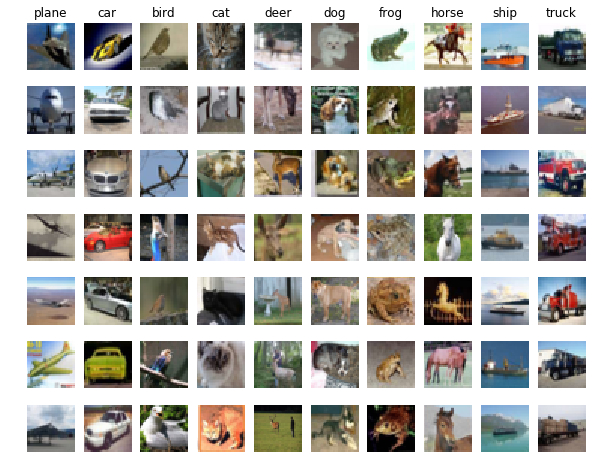

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']#这里定义了10类的名称
num_classes = len(classes)#取得总类别数
samples_per_class = 7#每一类展示的个数
for y, cls in enumerate(classes):#enumerate函数比较经常用，分别取出index和对应的元素
    idxs = np.flatnonzero(y_train == y)#np.flatnonzero()返回的是ndarray中展平后非零元素的索引位置
    idxs = np.random.choice(idxs, samples_per_class, replace=False)#从所给的1-D向量中选7个样本，如果不指定就是均匀分布
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.


#翻译：将数据分割为训练，验证和测试集。另外我们将创建一个小的“发展集”作为训练集的子集，这样我们能用发展集使得我们的代码运行更快

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.验证集将会是从原始的训练集中分割出来的可数的数据样本点
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.训练集用的是开始的数据可训练的样本点、
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.我们也可以从训练集中随机抽取一小部分的数据点作为发展集
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set. 使用前num_test个训练集点作为训练集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
X_train.shape

(49000, 32, 32, 3)

In [9]:
# Preprocessing: reshape the image data into rows，数据预处理，将每副图像数据重塑性为一行数据。
#np.reshape(kkk,-1),其中kkk为任意有具体含义的数字时，-1表示并不因为指定，由前一个参数和总的参数决定“-1”位置代表的数据。
#将所有样本，各自拉成一个行向量，所构成的二维矩阵，每一行就是一个样本，即一行有32X32X3个列，每一列表示一个特征。
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
#很正常地，要打印出来数据的形状看看。
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


(3072,)
[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


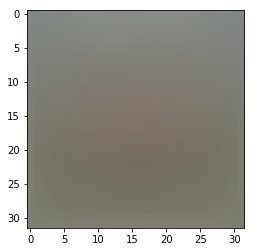

In [10]:
# Preprocessing: subtract the mean image，预处理，减去图像的平均值，中心化有两种，一种是3个通道颜色的中心值各是多少，一种是图片上每个特征的平均值是多少。
# first: compute the image mean based on the training data，首先，基于训练数据，计算图像的平均值
mean_image = np.mean(X_train, axis=0)#计算每一列特征的平均值，共32x32x3个特征
print(mean_image.shape)
print(mean_image[:10]) # print a few of the elements，查看一下特征的数据
plt.figure(figsize=(4,4))#指定画图的框图大小
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image，将平均值可视化出来。
plt.show()

In [11]:
# second: subtract the mean image from train and test data#
#去中心化
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [12]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
#把偏置b放进x里面去，这样就能统一方程形式。b当成X的一部分，x取值恒为1.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)#最后得到各个数据集的shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

开始写code环节了，这部分的code在 xxx/cs231n/classifiers/linear_svm.py 里，请按要求补充

In [13]:
# Evaluate the naive implementation of the loss we provided for you:
#计算我们提供给你的简单的损失
#这里如果有一个报错，2.7因为你要引入一个past的库，但是这个呢。。。在future里。。。所以你要pip install future，所以要多用google 
#python3中 xrange已经改为range。。。
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
#真的很小啊，先标准正态随机然后取0.0001,这种初始化有问题，10层顶天了，具体见后面课程
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)#从dev数据集种的样本抽样计算的loss是。。。大概估计下多少，随机几次，loss在8至9之间
print('loss: %f' % (loss, ))

loss: 9.417096


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [14]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you
print('---------------')
# Compute the loss and its gradient at W.

#输出是grad_check_sparse函数的结果,2种情况下，可以看出，其实2种算法误差已经几乎不计了。。。
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
print('+++++++++++++++++')
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
print('@@@@@@@@@@@@@@@@')
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
print('***************')
grad_numerical = grad_check_sparse(f, W, grad)
print('::::::::::::::::')
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
print('***************')
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
print('%%%%%%%%%%%%%%%')
grad_numerical = grad_check_sparse(f, W, grad)

---------------
+++++++++++++++++
@@@@@@@@@@@@@@@@
***************
numerical: 4.374474 analytic: 4.374474, relative error: 1.015691e-12
numerical: 6.078824 analytic: 6.078824, relative error: 5.609252e-11
numerical: 5.147538 analytic: 5.147538, relative error: 9.815960e-12
numerical: -9.483265 analytic: -9.483265, relative error: 7.616785e-12
numerical: -22.481870 analytic: -22.481870, relative error: 7.357678e-12
numerical: -5.599093 analytic: -5.599093, relative error: 5.088738e-12
numerical: 14.433376 analytic: 14.433376, relative error: 1.940539e-11
numerical: -16.998000 analytic: -16.998000, relative error: 2.118555e-11
numerical: -28.237744 analytic: -28.237744, relative error: 1.651817e-12
numerical: 35.408621 analytic: 35.408621, relative error: 8.001593e-12
::::::::::::::::
***************
%%%%%%%%%%%%%%%
numerical: 27.742121 analytic: 27.738151, relative error: 7.155358e-05
numerical: -40.339974 analytic: -40.338987, relative error: 1.223576e-05
numerical: 0.845399 analytic: 

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *解析解和数值逼近解的区别，而数值解是用前后2个很小的随机尺度(比如0.00001)进行计算，当Loss不可导的，两者会出现差异。*

In [15]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.417096e+00 computed in 0.121770s
Vectorized loss: 9.417096e+00 computed in 0.005394s
difference: 0.000000


In [16]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
#结论：结果一样，向量化快一些
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.127225s
Vectorized loss and gradient: computed in 0.003415s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [17]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 406.551290
iteration 100 / 1500: loss 240.613943
iteration 200 / 1500: loss 146.111274
iteration 300 / 1500: loss 90.213982
iteration 400 / 1500: loss 56.328602
iteration 500 / 1500: loss 35.504821
iteration 600 / 1500: loss 23.727488
iteration 700 / 1500: loss 15.755706
iteration 800 / 1500: loss 11.425011
iteration 900 / 1500: loss 9.055450
iteration 1000 / 1500: loss 7.637563
iteration 1100 / 1500: loss 6.671778
iteration 1200 / 1500: loss 5.914076
iteration 1300 / 1500: loss 5.219254
iteration 1400 / 1500: loss 5.034812
That took 3.781817s


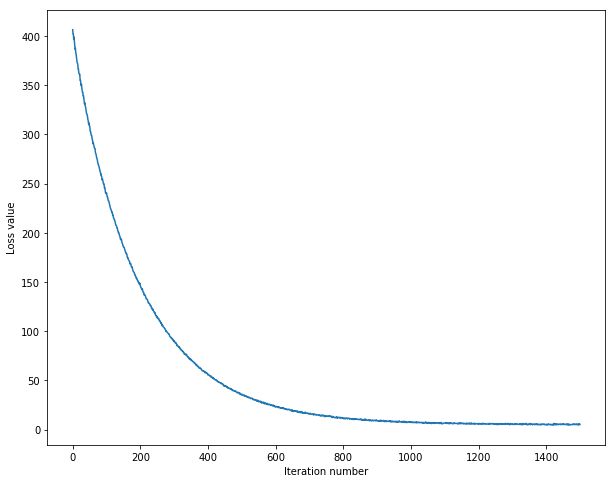

In [18]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380776
validation accuracy: 0.392000


In [41]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# 设置学习率和正则化强度，多设几个靠谱的，可能会好一点。
learning_rates = [1e-7, 3e-7, 5e-7, 7e-7, 9e-7, 5e-5]
regularization_strengths = [2e4, 3e4, 4e4, 5e4, 6e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for rate in learning_rates:
    for regular in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=rate, reg=regular,
                      num_iters=1000)
        y_train_pred = svm.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(rate, regular)]=(accuracy_train, accuracy_val)
        if (best_val < accuracy_val):
            best_val = accuracy_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.371776 val accuracy: 0.381000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.377347 val accuracy: 0.390000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.374612 val accuracy: 0.383000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.368122 val accuracy: 0.379000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.363980 val accuracy: 0.380000
lr 3.000000e-07 reg 2.000000e+04 train accuracy: 0.372122 val accuracy: 0.376000
lr 3.000000e-07 reg 3.000000e+04 train accuracy: 0.366388 val accuracy: 0.369000
lr 3.000000e-07 reg 4.000000e+04 train accuracy: 0.345633 val accuracy: 0.344000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.356245 val accuracy: 0.366000
lr 3.000000e-07 reg 6.000000e+04 train accuracy: 0.352020 val accuracy: 0.376000
lr 5.000000e-07 reg 2.000000e+04 train accuracy: 0.346735 val accuracy: 0.365000
lr 5.000000e-07 reg 3.000000e+04 train accuracy: 0.352939 val accuracy: 0.376000
lr 5.000000e-07 reg 4.000000

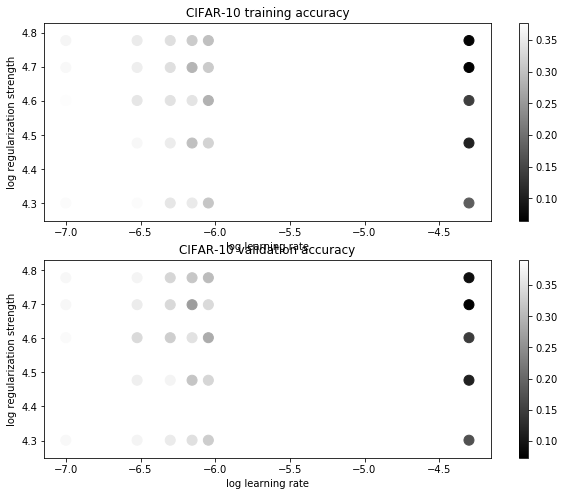

In [42]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [43]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.377000


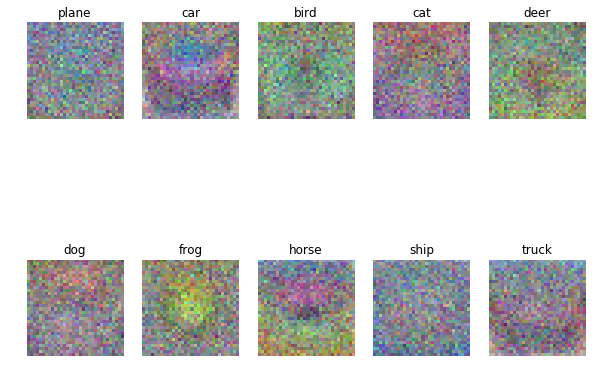

In [44]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *将学习到的权重可视化的效果可以看到，权重是对于原图像的特征提取，与原图像关系很大，很朴素的思想，在分类器权重向量上投影最大的向量得分应该最高，参与训练的点代表训练出来的权重向量最好的结果就是该训练的分类点上提现导出来的共性的方向。*